# <center>_Toxic Comment Detection_</center>

## ___Loading Data___

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labeled.csv", sep=",")
df['toxic'] = df['toxic'].apply(int)

___

## ___EDA___

In [3]:
df.shape

(14412, 2)

In [4]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [5]:
df.query('toxic == 1')['comment']

0                     Верблюдов-то за что? Дебилы, бл...\n
1        Хохлы, это отдушина затюканого россиянина, мол...
2                                Собаке - собачья смерть\n
3        Страницу обнови, дебил. Это тоже не оскорблени...
4        тебя не убедил 6-страничный пдф в том, что Скр...
                               ...                        
14404    ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...
14405    Сейчас все авиакомпании мира вместе со специал...
14407    Вонючий совковый скот прибежал и ноет. А вот и...
14408    А кого любить? Гоблина тупорылого что-ли? Или ...
14410    КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...
Name: comment, Length: 4826, dtype: object

In [6]:
df.query('toxic == 0')['comment']

6        В шапке были ссылки на инфу по текущему фильму...
12       Почитайте посты у этого автора,может найдете ч...
17       Про графику было обидно) я так то проходил все...
28       https: pp.userapi.com c848520 v848520411 11627...
35       Возьмём как пример Россию, западноевропейские ...
                               ...                        
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14399    65 А чего так мало? Вот у гражданина был рейти...
14406    Потому что запад прошел эту хуйню еще пару сот...
14409    Посмотрел Утомленных солнцем 2. И оказалось, ч...
14411    До сих пор пересматриваю его видео. Орамбо кст...
Name: comment, Length: 9586, dtype: object

In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# nltk.download('stopwords')

stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool=True):
    """Преобразует предложения в токены.
    По шагам:
    1) Токенизация - разбиение текста на отдельные слова и знаки пунктуации
    2) Удаляем знаки пунктуации
    3) Удаляем стоп-слова (часто используемые, не несущие смысловой нагрузки)
    4) Стемминг (stem - корень) - удаление окончаний и приведение к нижнему регистру
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

In [8]:
example = df.loc[1]['comment']
example

'Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n'

In [9]:
tokenize_sentence(example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True), 
                             token_pattern=None)

In [11]:
from sklearn.model_selection import train_test_split

features, labels = df['comment'], df['toxic']
features = vectorizer.fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

___

## ___Testing Different Models___

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [13]:
models = {'kNN': KNeighborsClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTree': DecisionTreeClassifier(), 
          'SGDClassifier': SGDClassifier(loss='log_loss')}

In [14]:
def models_report(models, x_train, x_test, y_train, y_test):
    report = pd.DataFrame()
    for model in models:
        clf = models[model].fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        report.loc[model, 'Precision'] = precision_score(y_test, y_pred)
        report.loc[model, 'Recall'] = recall_score(y_test, y_pred)
        report.loc[model, 'ROC-AUC'] = roc_auc_score(y_test, y_pred)
    return report

In [15]:
models_report(models, x_train, x_test, y_train, y_test)

,Precision,Recall,ROC-AUC
kNN,0.819218,0.521244,0.731685
LogisticRegression,0.916006,0.598964,0.785665
DecisionTree,0.702337,0.591710,0.732768
SGDClassifier,0.918699,0.585492,0.779712


___

## ___Search fo Hyperparameters___

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### _kNN_

In [17]:
knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': range(10, 21)}, 
                        verbose=0,
                        cv=3)
knn_grid.fit(x_train, y_train)

print(f'best params: {knn_grid.best_params_}')
print(f' best score: {knn_grid.best_score_}')
print(classification_report(y_test, knn_grid.predict(x_test)))

best params: {'n_neighbors': 11}
 best score: 0.8240090207303322
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1918
           1       0.86      0.58      0.69       965

    accuracy                           0.83      2883
   macro avg       0.84      0.77      0.79      2883
weighted avg       0.83      0.83      0.82      2883



___

### _Logistic Regression_

In [18]:
lr_grid = GridSearchCV(LogisticRegression(max_iter=300), 
                       param_grid={'C': np.logspace(-1, 2, 30)}, 
                       verbose=0,
                       cv=3)
lr_grid.fit(x_train, y_train)

print(f'best params: {lr_grid.best_params_}')
print(f' best score: {lr_grid.best_score_}')
print(classification_report(y_test, lr_grid.predict(x_test)))

best params: {'C': 23.95026619987486}
 best score: 0.8604388932257785
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1918
           1       0.86      0.72      0.78       965

    accuracy                           0.87      2883
   macro avg       0.86      0.83      0.84      2883
weighted avg       0.87      0.87      0.86      2883



In [20]:
from sklearn.metrics import precision_recall_curve

pr, rc, ths = precision_recall_curve(y_true=y_test, 
                                     probas_pred=lr_grid.predict_proba(x_test)[:,1])

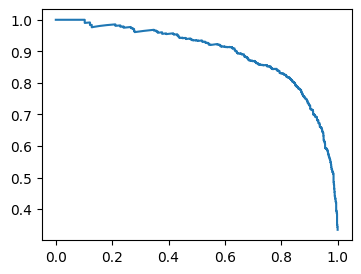

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(4, 3))
plt.plot(rc, pr)

In [22]:
pr_index = np.where(pr > 0.95)[0][0]
threshold = ths[pr_index].round(4)
probas = (lr_grid.predict_proba(x_test)[:,1] > threshold)
print(f'Precision: {precision_score(y_test, probas).round(4)}')
print(f'   Recall: {recall_score(y_test, probas).round(4)}')

Precision: 0.9501
   Recall: 0.4342


In [23]:
print(f'Threshold: {threshold}')

Threshold: 0.8663


___

### _Gradient Descent_

In [24]:
sgd_grid = GridSearchCV(SGDClassifier(loss='log_loss', early_stopping=True, validation_fraction=0.2, random_state=0), 
                        param_grid={'learning_rate': ['optimal'], 
                                    'alpha' : [0.00023, 0.001, 0.01]}, 
                        cv=5)
sgd_grid.fit(x_train, y_train)

print(f'best params: {sgd_grid.best_params_}')
print(f' best score: {sgd_grid.best_score_}')
print(classification_report(y_test, sgd_grid.predict(x_test)))

best params: {'alpha': 0.00023, 'learning_rate': 'optimal'}
 best score: 0.7991152383765447
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1918
           1       0.95      0.46      0.62       965

    accuracy                           0.81      2883
   macro avg       0.87      0.72      0.75      2883
weighted avg       0.84      0.81      0.79      2883



___

### _Trying to create the grid search function_

In [38]:
scores = []
for alpha in np.linspace(0.0001, 0.001, 100):
    sgd_grid = SGDClassifier(loss='log_loss', alpha=alpha, early_stopping=True, validation_fraction=0.2, random_state=0)
    sgd_grid.fit(x_train, y_train)
    prec = precision_score(y_test, sgd_grid.predict(x_test))
    rec = recall_score(y_test, sgd_grid.predict(x_test))
    if prec > 0.95:
        scores.append((rec, alpha.round(6)))

In [40]:
best_alpha = max(scores)[1]
best_alpha

0.000227

___

### _Decision Tree_

___

### _SVM_

___

## ___Predictions___

In [ ]:
def toxic_checker(text: str):
    if sgd_pipeline.predict([text])[0]:
        return 'TOXIC'
    else:
        return 'normal'

In [ ]:
# toxic_checker('иди гуляй отсюда по добру по здорову, ты неприятен')